<a href="https://colab.research.google.com/gist/jacobdanovitch/187d4fb71da7b1cbb82a8382bbf8952c/twtc-topic-models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://stackabuse.com/python-for-nlp-topic-modeling/

In [163]:
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, SparsePCA as PCA, LatentDirichletAllocation as LDA

import nltk
from nltk.corpus import stopwords #; nltk.download('stopwords')

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [241]:
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.21.3)


In [0]:
from sknn import ae#, mlp

In [161]:
df = pd.read_csv('preprocessed.csv')[['report', 'label']]

pos_docs = df[df.label == 1].report
neg_docs = df[df.label == 0].report

print(df.shape)
df.head()

(5824, 2)


,report,label
0,PERSON is a Level NUMBER sex offender and woul...,0
1,PERSON made headlines for all the wrong reason...,0
2,"The ORGANIZATION have acquired PERSON twice, f...",1
3,Signed for an above-slot $NUMBER million as a ...,1
4,"It often takes time for those high-ceilinged, ...",0


In [0]:
full_corpus = pd.read_csv('filled_twtc_13k.csv').report.dropna()

In [0]:
MODELS = {
    "lda": (CountVectorizer, LDA),
    "nmf": (TfidfVectorizer, NMF),
    "nmf2": (CountVectorizer, NMF),
    'lsi': (CountVectorizer, TruncatedSVD),
    'ae': (CountVectorizer, lambda: ae.AutoEncoder(
            layers=[
                ae.Layer("Tanh", units=128),
                ae.Layer("Sigmoid", units=64)],
            learning_rate=0.002,
            n_iter=10))
}

def corpus2vec(topic_model, docs, transform=np.mean):
    topics = topic_model.transform(docs)
    return transform(topics, axis=0)

def closest_topics(topic_model, docs, n_topics=5):
    similar = corpus2vec(topic_model, docs).argsort()[-n_topics:]
    for n in similar:
        print(fetch_topic(topic_model, n))
        
        
def fetch_topic(topic_model, n):
    params = topic_model.steps
    model = params[1][1]
    vect = params[0][1]
    
    topic_ids = model.components_[n].argsort()[-10:]
    return [vect.get_feature_names()[i] for i in topic_ids]

def visualize_topics(topic_model, topics, docs, annot=False):
  doc_matrix = map(lambda x: corpus2vec(topic_model, x), docs.values())
  doc_matrix = np.concatenate([d.reshape(-1, 1) for d in doc_matrix], axis=1)
  doc_matrix = (doc_matrix - doc_matrix.mean(axis=0)) / doc_matrix.std(axis=0)

  doc_df = pd.DataFrame(doc_matrix, index=topics, columns=docs.keys())
  return sns.heatmap(doc_df, cmap=sns.diverging_palette(255, 0, sep=64, n=256), annot=annot, center=0), doc_matrix




def fit_topic_model(name, docs, n_topics=5):
  Vectorizer, Model = MODELS[name.lower()]
  sw = {*stopwords.words('english'), 
        'gpe', 'person', 'number', 'organization', 'one', 'two', 'three', 'double', 'triple', 'numberth', 'second', 'first',
        'base', 'big', 'league',  'ball', 'overall', 'pick', 'draft'
  }
  return make_pipeline(
      Vectorizer(max_df=0.8, min_df=5, ngram_range=(1,1), stop_words=sw, use_idf=True),#, smooth_idf=True), # 
      Model(n_components=n_topics, random_state=1010100)#42)

  ).fit(docs)

In [420]:
n_topics = 10
topic_model = fit_topic_model('nmf', df.report, n_topics=n_topics)

pd.DataFrame([fetch_topic(topic_model, n) for n in range(n_topics)])

,0,1,2,3,4,5,6,7,8,9
0,play,bases,outfielder,plus,fielder,outfield,tools,speed,field,center
1,also,starter,delivery,changeup,low,pitches,curveball,fastball,numbers,mph
2,feel,pitching,chance,changeup,curve,fastball,stuff,good,pitch,average
3,frame,prep,summer,top,scouts,senior,round,spring,school,high
4,game,percent,backstop,catching,defensive,receiving,skills,plate,catcher,behind
5,swing,college,strength,year,season,left,handed,homers,average,pro
6,instincts,contact,infield,arm,position,international,good,range,hands,shortstop
7,inning,college,fastball,starter,stuff,relief,slider,role,reliever,bullpen
8,missed,time,full,shoulder,elbow,injury,healthy,back,season,surgery
9,way,baseman,enough,third,profile,raw,corner,bat,hit,power


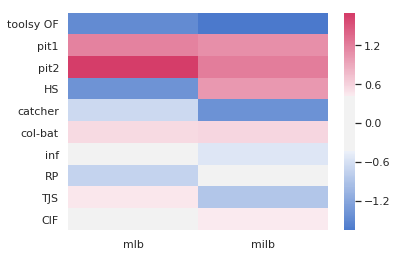

In [434]:
topics = ['toolsy OF', 'pit1', 'pit2', 'HS', 'catcher', 'col-bat', 'inf', 'RP', 'TJS', 'CIF']

hm, doc_matrix = visualize_topics(topic_model, topics, {'mlb': pos_docs, 'milb': neg_docs})
plt.gcf().subplots_adjust(left=0.15)
plt.show()